# Introduction

This notebook details model 1 architecture and training. Model 1 is an ensemble of 5 models trained on the ubiquant dataset using stratified cross validation(5 folds). There will be other ensembles of models that will be utilized in conjuction with model 1 to make the final predictions on the test set for submission.

This notebook is made up of the following sections:

1. Importing libraries
2. Data importation
3. Data wrangling
4. Utility functions
5. Model architecture
6. Model training
7. Api Submission
8. Evaluation
9. Next Steps

## 1. Importing Libraries

This section imports all the necessary libraries for data importation, wrangling, visualization and modeling.

In [1]:
# Import Libraries
import os                                               # Functions for interacting with the OS
import pandas as pd                                     # Data manipulation
import numpy as np                                      # Mathematical functions
import gc                                               # Automatically releases memory when an object is no longer used
import matplotlib.pyplot as plt                         # Plotting
import tensorflow as tf                                 # Deep learning API
from tensorflow.keras import layers                     # Deep learning (defining layers)
from tensorflow import keras                            # Deep learning framework
from scipy import stats                                 # Scientific computing and technical computing
import random                                           # Generate random numbers
import seaborn as sns                                   # Plotting
from scipy.stats import *                               # Scientific computation and functions
import warnings                                         # Manage warning messages and outputs
import pickle                                           # Serializing object structures
import lightgbm as lgb                                  # high performance gradient boosting framework
from sklearn.model_selection import train_test_split    # Splitting data into train and test set



## 2. Data Importation

This competition's dataset (18.55 GB) is too large. We will use another dataset converted to utilize less memory in pickle format. The dataset is in pickle format and utilizes less memory.

In [2]:
# Track time to load dataset
!%%time

# Declare number of ananonymized features
n_features = 300

# Select anonymized features
features = [f'f_{i}' for i in range(n_features)]

# Import train set
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')


/bin/bash: line 0: fg: no job control


## 3. Data Wrangling

This section handles:

* Selecting the independent and dependent features from the data set.
* Dropping time_id feature (will not be utilized in modeling).
* Create an integer look up layer for investment _id feature.

In [3]:
# Dataset dimensions
train.shape

(3141410, 303)

In [4]:
# Glimpse train set
train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


In [5]:
# Select investment _id feature for processing
investment_id = train.pop("investment_id")
investment_id.head()

0    1
1    2
2    6
3    7
4    8
Name: investment_id, dtype: uint16

In [6]:
# Drop time_id feature

_ = train.pop("time_id")

In [7]:
# Select dependent / target feature
y = train.pop("target")
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

### 3.1 IntegerLookup Layer

A integer lookup layer is a preprocessing layer which maps integer features to contiguous ranges. It turns integer categorical values into an encoded representation that can be read by an Embedding layer or Dense layer.

This layer maps a set of arbitrary integer input tokens into indexed integer output via a table-based vocabulary lookup.

The integer lookup layer will be one of two input branches for the multi-input keras model. Having a look up layer enables the keras deep learning model to handle both categorical and numeric features.

In [8]:
# Track processing time
!%%time

# Create a list of unique investment_ids
investment_ids = list(investment_id.unique())

# maximum tokens
investment_id_size = len(investment_ids) + 1

# initialize layer
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)

# Adapt layer to data (investment_ids)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

/bin/bash: line 0: fg: no job control


2022-03-04 23:01:55.473721: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-04 23:01:55.585837: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## 4. Utility Functions

This section defines utility functions to preprocess the data prior submitting to the kaggle API.

In [9]:
# Making Tesorflow dataset
import tensorflow as tf
def preprocess(X, y):
    
    """
    .Pre-processing a tensorflow dataset
    
    Parameters
    ----------
    X : array, a list of features

    y : array, a feature
    
    
    """
    return X, y


def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    
    """ Function to create a source dataset compatable with tensorflow. 
    In addition a dataset transformation is applied  and the data is shuffled 
    if it is part of the training set. 

    Parameters
    ----------
    feature : array, shape = [n, 300]
        300 annonymised features.
    investment_id : list of int, shape = [n]
        List of investment Ids.
    y : array, shape = [n]
        Array containing target values we wish to predict.
    batch_size : int, default = 1024
        Size of batches.
    mode : string, default = "train"
        Variable used to specify if the data if from the training, test or
        validation data sets.
    
    Returns
    -------
    ds : tensorflow dataset, class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset' 
        Dataset in format compatible for training model.
    
    """
    
    ## Read elements from memory
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    
    ## Map preprocess function
    ds = ds.map(preprocess)
    
    ## If mode is set to train shuffle data
    if mode == "train":
        ds = ds.shuffle(4096)
        
    # Combine consecutive elements of this dataset into batches.
    # Cache the elements in dataset
    # Allow later elements to be prepared while the current element is being processed (prefetch)
    
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 5. Model Architecture

This section defines the model architecture:

* Layers
* Activation functions
* Optimizer
* Loss function
* Metrics to be tracked


The model architecture is a multi input keras network with 2 input branches. First branch handles investment Ids (categorical feature) while the second branch will handle remaining anonymalized 300 features (numeric features).

### 5.1 Activation Function

Swish activation function is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks, it is unbounded above and bounded below.


### 5.2 Optimizer

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Adam optimizer will be used with a learning rate of 0.001

### 5.3 Loss Function

The model will attempt to minimize MSE (mean squared error).

### 5.4 Metrics

The following metrics will be tracked during training

1. **Mean Squared Error (MSE)** : Average squared difference between the estimated values and the actual value.
2. **Mean Absolute Error (MAE)** : Average of errors between paired observations. 
3. **Mean Absolute Percentage Error (MAPE)** : measures of how accurate a focus is b percentage.

In [10]:

def get_model():
    
    """ 
    
    Function to define the multi-input keras model architecture. 

    Returns
    -------
    
    model : model, class 'keras.engine.functional.Functional'
        Model groups layers into an object with training and inference features.
    
    """
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    # Branch 1
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    # Turns positive integers (indexes) into dense vectors of fixed size
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x) 
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    # Branch 2
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    # Takes as input a list of tensors and returns a single tensor that is the concatenation of all inputs
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    
    output = layers.Dense(1)(x)
    
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

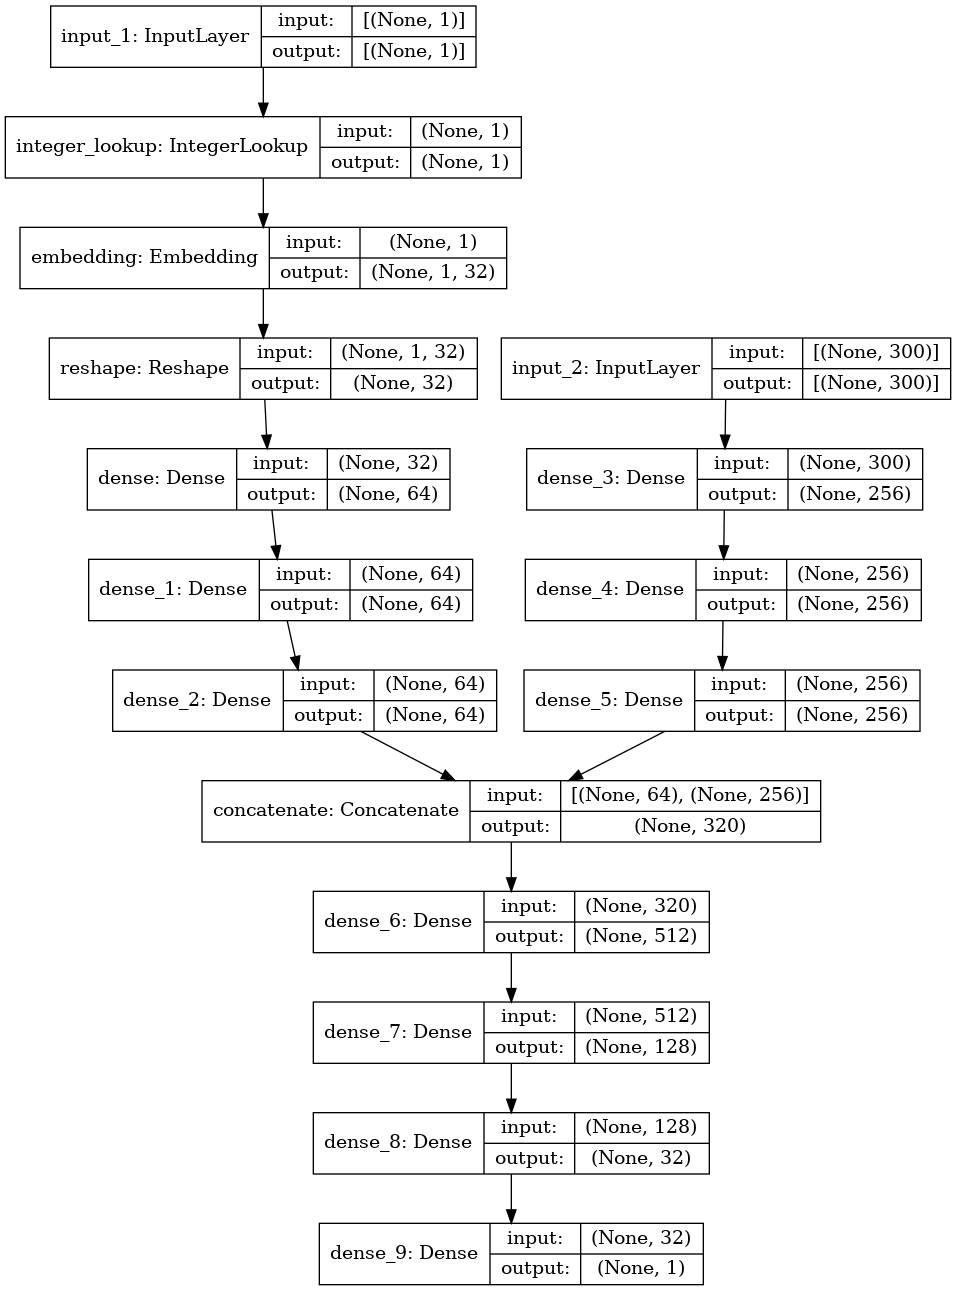

In [11]:
# Model summary and visualizating layout
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## 6. Model Training

* Statified cross validation (a resampling procedure) will be applied to train 5 folds of data resulting in 5 models per fold.
* Model will be trained with batchsize of 1024 (default from make datasets function).
* Callbacks will used to avoid overfitting by early stopping with a patience of 10 epochs.
* The model is set for 20 epochs.


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/20
2455/2455 [==============================] - 135s 54ms/step - loss: 0.9106 - mse: 0.8313 - mae: 0.6245 - mape: 131513.7969 - rmse: 0.9118 - val_loss: 0.8413 - val_mse: 0.8397 - val_mae: 0.6274 - val_mape: 253492.0156 - val_rmse: 0.9164


2022-03-04 23:04:39.005465: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
2455/2455 [==============================] - 125s 51ms/step - loss: 0.8304 - mse: 0.8274 - mae: 0.6231 - mape: 145924.2188 - rmse: 0.9096 - val_loss: 0.8405 - val_mse: 0.8388 - val_mae: 0.6280 - val_mape: 235201.9844 - val_rmse: 0.9159
Epoch 3/20
2455/2455 [==============================] - 124s 50ms/step - loss: 0.8288 - mse: 0.8234 - mae: 0.6214 - mape: 151552.1875 - rmse: 0.9074 - val_loss: 0.8397 - val_mse: 0.8381 - val_mae: 0.6276 - val_mape: 224730.0156 - val_rmse: 0.9155
Epoch 4/20
2455/2455 [==============================] - 126s 51ms/step - loss: 0.8278 - mse: 0.8218 - mae: 0.6208 - mape: 148406.4219 - rmse: 0.9065 - val_loss: 0.8373 - val_mse: 0.8357 - val_mae: 0.6283 - val_mape: 168933.0000 - val_rmse: 0.9142
Epoch 5/20
2455/2455 [==============================] - 129s 52ms/step - loss: 0.8259 - mse: 0.8195 - mae: 0.6200 - mape: 150618.2188 - rmse: 0.9052 - val_loss: 0.8381 - val_mse: 0.8362 - val_mae: 0.6276 - val_mape: 187494.8594 - val_rmse: 0.9144
Epoch 6/20
2

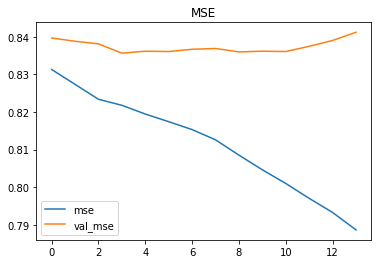

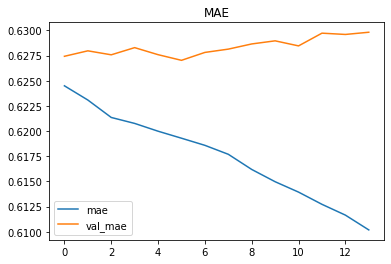

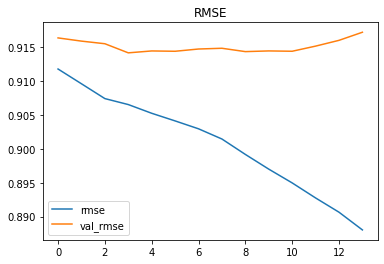

Epoch 1/20
2455/2455 [==============================] - 137s 55ms/step - loss: 0.9119 - mse: 0.8321 - mae: 0.6248 - mape: 127827.4844 - rmse: 0.9122 - val_loss: 0.8397 - val_mse: 0.8366 - val_mae: 0.6305 - val_mape: 119080.5938 - val_rmse: 0.9146
Epoch 2/20
2455/2455 [==============================] - 128s 52ms/step - loss: 0.8319 - mse: 0.8280 - mae: 0.6233 - mape: 142057.8906 - rmse: 0.9099 - val_loss: 0.8373 - val_mse: 0.8345 - val_mae: 0.6286 - val_mape: 134197.6094 - val_rmse: 0.9135
Epoch 3/20
2455/2455 [==============================] - 129s 52ms/step - loss: 0.8303 - mse: 0.8258 - mae: 0.6225 - mape: 142135.5781 - rmse: 0.9087 - val_loss: 0.8360 - val_mse: 0.8331 - val_mae: 0.6283 - val_mape: 170588.7969 - val_rmse: 0.9127
Epoch 4/20
2455/2455 [==============================] - 129s 53ms/step - loss: 0.8291 - mse: 0.8235 - mae: 0.6216 - mape: 146564.3125 - rmse: 0.9075 - val_loss: 0.8360 - val_mse: 0.8325 - val_mae: 0.6285 - val_mape: 130969.4375 - val_rmse: 0.9124
Epoch 5/20
2

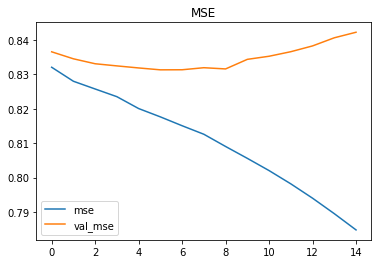

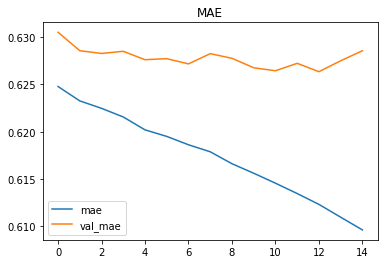

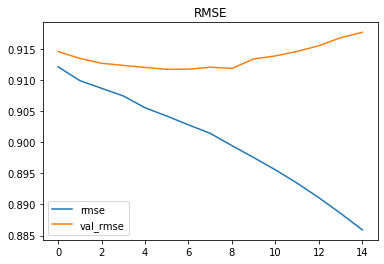

Epoch 1/20
2455/2455 [==============================] - 137s 55ms/step - loss: 0.9104 - mse: 0.8315 - mae: 0.6246 - mape: 124488.0391 - rmse: 0.9119 - val_loss: 0.8409 - val_mse: 0.8394 - val_mae: 0.6298 - val_mape: 147930.3281 - val_rmse: 0.9162
Epoch 2/20
2455/2455 [==============================] - 131s 53ms/step - loss: 0.8305 - mse: 0.8274 - mae: 0.6232 - mape: 137299.6250 - rmse: 0.9096 - val_loss: 0.8398 - val_mse: 0.8382 - val_mae: 0.6302 - val_mape: 156514.6719 - val_rmse: 0.9155
Epoch 3/20
2455/2455 [==============================] - 127s 52ms/step - loss: 0.8286 - mse: 0.8241 - mae: 0.6217 - mape: 142776.0938 - rmse: 0.9078 - val_loss: 0.8393 - val_mse: 0.8375 - val_mae: 0.6301 - val_mape: 155312.3125 - val_rmse: 0.9151
Epoch 4/20
2455/2455 [==============================] - 130s 53ms/step - loss: 0.8275 - mse: 0.8218 - mae: 0.6207 - mape: 142330.9219 - rmse: 0.9065 - val_loss: 0.8377 - val_mse: 0.8366 - val_mae: 0.6282 - val_mape: 185858.2812 - val_rmse: 0.9146
Epoch 5/20
2

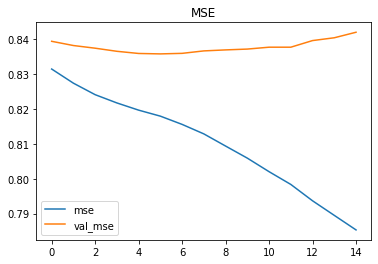

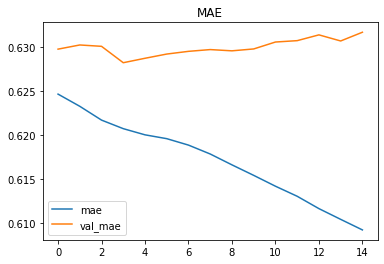

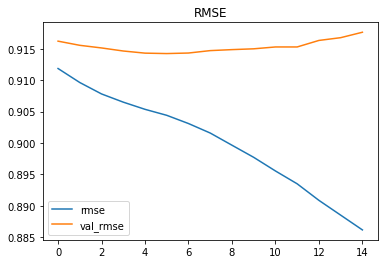

Epoch 1/20
2455/2455 [==============================] - 130s 52ms/step - loss: 0.9111 - mse: 0.8318 - mae: 0.6247 - mape: 125133.1172 - rmse: 0.9120 - val_loss: 0.8446 - val_mse: 0.8405 - val_mae: 0.6309 - val_mape: 88536.4609 - val_rmse: 0.9168
Epoch 2/20
2455/2455 [==============================] - 136s 55ms/step - loss: 0.8309 - mse: 0.8274 - mae: 0.6231 - mape: 143109.3438 - rmse: 0.9096 - val_loss: 0.8393 - val_mse: 0.8373 - val_mae: 0.6288 - val_mape: 147024.4688 - val_rmse: 0.9151
Epoch 3/20
2455/2455 [==============================] - 122s 50ms/step - loss: 0.8291 - mse: 0.8251 - mae: 0.6221 - mape: 148205.5938 - rmse: 0.9083 - val_loss: 0.8387 - val_mse: 0.8373 - val_mae: 0.6285 - val_mape: 156221.9219 - val_rmse: 0.9150
Epoch 4/20
2455/2455 [==============================] - 125s 51ms/step - loss: 0.8282 - mse: 0.8231 - mae: 0.6213 - mape: 143726.8906 - rmse: 0.9073 - val_loss: 0.8383 - val_mse: 0.8368 - val_mae: 0.6280 - val_mape: 171051.1250 - val_rmse: 0.9147
Epoch 5/20
24

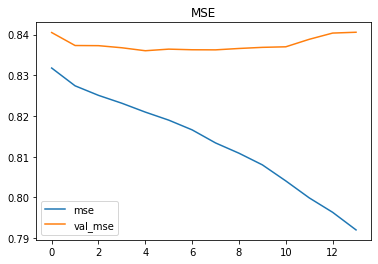

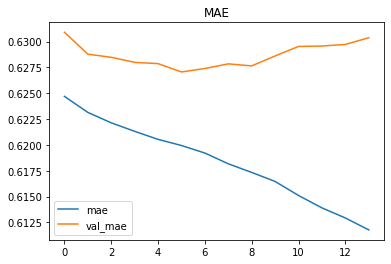

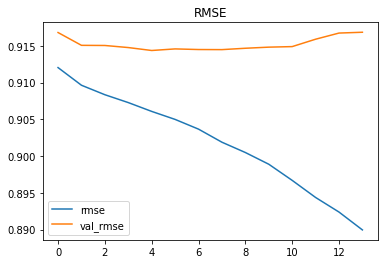

Epoch 1/20
2455/2455 [==============================] - 143s 58ms/step - loss: 0.9128 - mse: 0.8333 - mae: 0.6251 - mape: 127824.8750 - rmse: 0.9129 - val_loss: 0.8322 - val_mse: 0.8308 - val_mae: 0.6257 - val_mape: 184670.0469 - val_rmse: 0.9115
Epoch 2/20
2455/2455 [==============================] - 125s 51ms/step - loss: 0.8331 - mse: 0.8297 - mae: 0.6238 - mape: 144029.3125 - rmse: 0.9109 - val_loss: 0.8329 - val_mse: 0.8294 - val_mae: 0.6247 - val_mape: 204409.3125 - val_rmse: 0.9107
Epoch 3/20
2455/2455 [==============================] - 129s 52ms/step - loss: 0.8314 - mse: 0.8268 - mae: 0.6226 - mape: 149671.4688 - rmse: 0.9093 - val_loss: 0.8326 - val_mse: 0.8290 - val_mae: 0.6241 - val_mape: 192378.8750 - val_rmse: 0.9105
Epoch 4/20
2455/2455 [==============================] - 128s 52ms/step - loss: 0.8296 - mse: 0.8234 - mae: 0.6212 - mape: 154931.8906 - rmse: 0.9074 - val_loss: 0.8327 - val_mse: 0.8278 - val_mae: 0.6232 - val_mape: 172822.7656 - val_rmse: 0.9099
Epoch 5/20
2

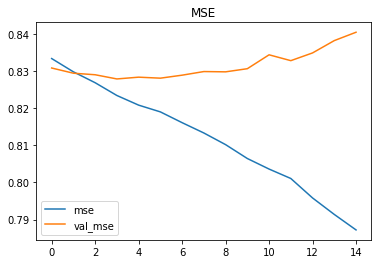

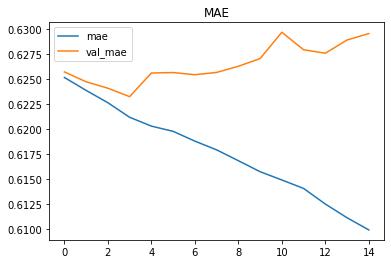

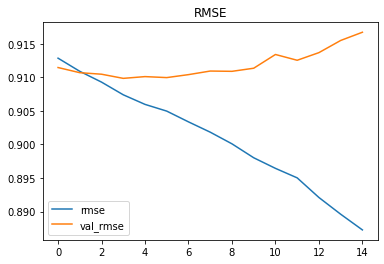

CPU times: user 6h 25min 26s, sys: 20min 4s, total: 6h 45min 30s
Wall time: 2h 44min 35s


In [12]:
%%time

# Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label.
from sklearn.model_selection import StratifiedKFold

# Create 5 folds
kfold = StratifiedKFold(5, shuffle=True, random_state=42)

# List to store models
models = []

# Loop over folds

for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    
    # Split dataset
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    
    # Call model
    model = get_model()
    
    # Use callbacks to stop model training if model perfomance is not improving
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    
    # Fit model
    history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    
    # append model to models list
    model = keras.models.load_model(f"model_{index}")
    models.append(model)
    
    # Make predictions for validation set and get pearson correlation coefficient
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    
    # Create a dataframe of mean squared errors for train and validation sets and plot the metrics
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    
    # Create a dataframe of mean absolute errors for train and validation sets and plot the metrics
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    
    # Create a dataframe of root mean squared errors for train and validation sets and plot the metrics
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    
    # Remove un-neccesary objects from memory
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    

## 7. API Submission

This section preprocesses the test set from the API and makes predictions from the 5 models trained on the cross validated dataset. The five predictions are averaged to a single prediction by the inference function.

In [13]:
def preprocess_test(investment_id, feature):
    """ Functions to pre-process test set.
    
    Parameters
    ----------
    investment_id : list of int, shape = [n]
        List of investment Ids.
    feature : array, shape = [n, 300]
        300 annonymised features.

    Returns
    -------

    """
    return (investment_id, feature), 0



def make_test_dataset(feature, investment_id, batch_size=1024):
    
    """ Function to create a source dataset from the test features compatable 
    with tensorflow. 
    In addition a dataset transformation is applied  and the data is shuffled 
    if it is part of the training set.

    Parameters
    ----------
    feature : array, shape = [n, 300]
        Ground truth (correct) target values.
    investment_id : list of int, shape = [n]
        List of investment Ids.
    batch_size : int, default = 1024
        Size of batches.
    
    Returns
    -------
    ds : tensorflow dataset, class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset' 
        Dataset in format compatible for training model.
        .
    """
    
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def inference(models, ds):
    
    """ Make predictions unsing n models in models and return mean of predictions.

    Parameters
    ----------
    models : array like, shape = [n]
        Trained models.
    ds : tensorflow dataset, class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset' 
        Dataset in format compatible for training model.
    
    Returns
    -------
    mean_y_pred : float
        Mean values of preditions made my each model in models.
    
    """
    
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

Finaly we call kagle's API for test data and make predictions

In [14]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


## 8 Evaluation

Submissions are evaluated on the mean of the Pearson correlation coefficient for each time ID.

The 5 model ensemble resulted in a score of **0.149**

## 9. Next Steps

The strategy is to use this model as an ensemble with other ensembled models to improve the scores.